This script is for loading and saving the image with a scale bar.

# Import libraries

You might need to install the scalebar library: $\mathtt{pip\; install\; matplotlib-scalebar}$

In [1]:
# Basic
import os, sys
from os.path import join
from importlib import reload

# Data
import numpy as np
import pandas as pd
import h5py

# Plotting
import imageio
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar

# skimage
import skimage as sk
from skimage.registration import phase_cross_correlation

# scipy
from scipy.ndimage import gaussian_filter, fourier_shift

# self-written library
sys.path.append(join(os.getcwd(), "library"))
import pymaxymus as mx

In [6]:
# interactive plotting (WIDGET for jupyter lab, NOTEBOOK for jupyter notebook)
import ipywidgets

%matplotlib widget

# Auto formatting
#%load_ext jupyter_black

# Experiment Specific functions

In [7]:
def FFT(image):
    """
    Fourier transform
    -------
    author: CK 2021
    """
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(image)))

In [8]:
# scipy
from scipy.ndimage import fourier_shift
from scipy.ndimage import shift as scipy_shift


def shift_image(image, shift, interpolation=True, out_dtype="numpy"):
    """
    Shifts image with sub-pixel precission in Fourier space


    Parameters
    ----------
    image: cupy array
        Moving image, will be shifted by shift vector

    shift: vector
        x and y translation in px

    out_dtype : string
        output data as numpy or cupy array

    Returns
    -------
    image_shifted: cupy/numpy array
        Shifted image
    -------
    author: CK 2023
    """

    # Shift Image
    image = np.array(image)

    if interpolation is True:
        shift_image = scipy_shift(image, shift, mode="reflect")
    else:
        shift_image = fourier_shift(np.fft.fft2(image), shift)
        shift_image = np.fft.ifft2(shift_image)
        shift_image = shift_image.real

    return shift_image


def image_registration(image_unproccessed, image_background, roi=None, im_out=False):
    """
    Aligns two images with sub-pixel precission through image registration


    Parameters
    ----------
    image_unproccessed: cupy array
        Moving image, will be aligned with respect to image_background

    image_background: cupy array
        static reference image

    roi: region of interest defining the region of the images used to calc
        the alignment

    im_out: bool
        return also corrected image if true

    Returns
    -------
    image_corrected: array
        Shifted/aligned moving image
    shift: array
        shift (dy,dx)
    -------
    author: CK 2022
    """

    # Calculate Shift
    if roi == None:
        shift, error, diffphase = phase_cross_correlation(
            image_background, image_unproccessed, upsample_factor=100
        )
    else:
        shift, error, diffphase = phase_cross_correlation(
            image_background[
                roi[2] : roi[3],
                image_unproccessed[roi[2] : roi[3], roi[0] : roi[1]],
                roi[0] : roi[1],
            ],
            upsample_factor=100,
        )

    # print(f'Detected pixel shift (y, x): {shift}')

    if im_out == True:
        # Shift Image
        image_corrected = shift_image(image_unproccessed, shift)

        return image_corrected, shift
    else:
        return shift

In [297]:
from ipywidgets import FloatRangeSlider, FloatSlider, Button, interact, IntSlider

def cimshow(im, **kwargs):
    """Simple 2d image plot with adjustable contrast.

    Returns matplotlib figure and axis created.
    """
    im = np.array(im)
    fig, ax = plt.subplots()
    im0 = im[0] if len(im.shape) == 3 else im
    mm = ax.imshow(im0, **kwargs)

    cmin, cmax, vmin, vmax = np.nanpercentile(im, [0.1, 99.9, 0.001, 99.999])
    # vmin, vmax = np.nanmin(im), np.nanmax(im)
    sl_contrast = FloatRangeSlider(
        value=(cmin, cmax),
        min=vmin,
        max=vmax,
        step=(vmax - vmin) / 500,
        layout=ipywidgets.Layout(width="500px"),
    )

    @ipywidgets.interact(contrast=sl_contrast)
    def update(contrast):
        mm.set_clim(contrast)

    if len(im.shape) == 3:
        w_image = IntSlider(value=0, min=0, max=im.shape[0] - 1)

        @ipywidgets.interact(nr=w_image)
        def set_image(nr):
            mm.set_data(im[nr])

    return fig, ax

In [296]:
def max_plot(
    data,
    destination,
    pixel_size,
    length_fraction,
    color,
    location=1,
    units="nm",
    cmap="gray",
    size=(2, 2),
    save=True,
    scale=(0, 100),
    rang=(0, -1),
):
    """
    Plot single image recorded at the MAXYMUS microscope at BESSY.
    INPUT:
        data: data set
        destination: filename where to save the image
        pixel_size: size of one pixel in nm (otherwise change units)
        length_fraction: length of the scale bar
        color: color of the scale bar ('w' for white and 'k' for black)
        location: location of the scale bar (default is 1, right upper corner)
        units: unit of the pixel_size (default is 'nm')
        cmap: matplotlib colormap (default is 'gray')
        save: boolean variable if you want to save the image at destination (default is True)
        scale: scale of the image in percentile (default is (0,100))
    OUTPUT:
        no output, plots the image
    KG 01.2020
    """
    mi, ma = np.nanpercentile(data[rang[0] : rang[1], :], scale)

    # plot the image and save it as .png
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(data, cmap=cmap, vmin=mi, vmax=ma, origin="lower")
    scalebar = ScaleBar(
        pixel_size,
        units=units,
        frameon=False,
        color=color,
        fixed_value=length_fraction,
        location=location,
    )
    ax.add_artist(scalebar)
    plt.tight_layout()
    if save:
        plt.savefig(destination, dpi=150)
    return fig, ax

# Load Data

Load the data.

1. Specify some parameters.
2. Load the header.
3. Load the image data.

# Functions

In [11]:
# List of h5 keys for simple loading
mnemonics = dict()
mnemonics["image"] = "/entry1/APD/data"
mnemonics["energy"] = "/entry1/APD/energy"
mnemonics["sample_x"] = "/entry1/APD/sample_x"
mnemonics["sample_y"] = "/entry1/APD/sample_y"
mnemonics["magnetic_field"] = "/entry1/APD/magnetic_field"

In [12]:
def load_image(im_id):
    fname = join(data_folder, "%s_%03d.hdf5" % (file_prefix, im_id))
    print("Loading: %s" % fname)

    if os.path.exists(fname):
        exist_flag = True
        with h5py.File(fname, "r") as f:
            image = f[mnemonics["image"]][()]
    else:
        print("File does not exist!")
        exist_flag = False
        image = np.array(np.zeros((2, 2)))

    return image, exist_flag


def load_images(im_id_list):
    images = []

    for im_id in im_id_list:
        image = load_image(im_id)
        images.append(image)

    return images


def get_pixel_size(im_id):
    fname = join(data_folder, "%s_%03d.hdf5" % (file_prefix, im_id))
    print("Loading: %s" % fname)
    with h5py.File(fname, "r") as f:
        sample_x = f[mnemonics["sample_x"]][()]
        sample_y = f[mnemonics["sample_y"]][()]

    # Calc pixel size from file
    pixel_size_x = np.round(np.mean(np.abs(sample_x[0:-2] - sample_x[1:-1])), 3)
    pixel_size_y = np.round(np.mean(np.abs(sample_y[0:-2] - sample_y[1:-1])), 3)

    return (pixel_size_y, pixel_size_x)

## Parameters

Specify the date from the data prefix. If you want to load an XMCD data set, set the boolean variable XMCD to True and specify positive and negative helicity image. Set the folder where the raw data is located (you might need to include a folder name according the the date via **'%i'%date**.

In [291]:
# Just Basic folder structures for loading and saving
# For maxymus folder
date = "2024-04-17"

# Combine paths
file_prefix = "Sample_Image_%s" % date

# Input folder
data_folder = join("Y:\\", date)
# data_folder = os.getcwd()

# save folder
folder_save = r"C:\Users\gaebel\Desktop\MBI Orga\Beamtimes\04_24_MAXYMUS\Bilder"
#folder_save = (r"C:\Users\klose\MBI - Klose\Projects\BESSY_MAXYMUS_24_04_Skyrmion\Analysis\%s"    % date)
# folder_save = join(os.getcwd(), "analysis")

# Other
entryNumber = "entry1"
detector = "APD"

# Save Name
# Create save folder of it does not exit yet
if not (os.path.exists(folder_save)):
    print("Creating folder " + folder_save)
    os.mkdir(folder_save)

In [292]:
# Define Scan id for loading
n_pos = 180

# do you have an xmcd data set? (record with both helicity)
XMCD = False

if XMCD is True:
    n_neg = 0

## Data

Load the data.

In [293]:
if XMCD:
    pos = load_image(n_pos)
    neg = load_image(n_neg)
    data = np.log(pos / neg)
    topo = pos + neg

    figure_save = join(folder_save, "MAXYMUS_%s-%03d_%03d.png" % (date, n_pos, n_neg))
    print("Image saved as: %s" % figure_save)

elif XMCD is False:
    data, _ = load_image(n_pos)
    figure_save = join(folder_save, "MAXYMUS_%s-%03d.png" % (date, n_pos))
    print("Image saved as: %s" % figure_save)

pixel_size, pixel_size_x = get_pixel_size(n_pos)
size = np.array(data.shape) / 50

Loading: Y:\2024-04-17\Sample_Image_2024-04-17_180.hdf5
Image saved as: C:\Users\gaebel\Desktop\MBI Orga\Beamtimes\04_24_MAXYMUS\Bilder\MAXYMUS_2024-04-17-180.png
Loading: Y:\2024-04-17\Sample_Image_2024-04-17_180.hdf5


# Plot single image

interactive(children=(FloatRangeSlider(value=(1137.0, 1208.0920000000006), description='contrast', layout=Layo…

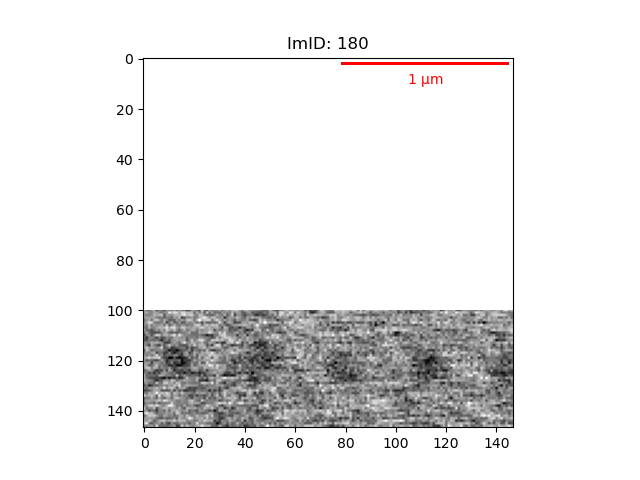

In [298]:
# Plotting with cimshow
fig, ax = cimshow(np.flipud(data), cmap="gray")
ax.set_title("ImID: %03d" % n_pos)
scalebar = ScaleBar( pixel_size, units="um", frameon=False, color="r", fixed_value=1, location=1)

plt.gca().add_artist(scalebar)
# fig.colorbar(mm, ax=ax)

In [299]:
# Execute save
fname = join(folder_save, "MAXYMUS_%s-%03d.png" % (date, n_pos))
print("Saving: %s" % fname)
plt.savefig(fname, dpi=300)

Saving: C:\Users\gaebel\Desktop\MBI Orga\Beamtimes\04_24_MAXYMUS\Bilder\MAXYMUS_2024-04-17-180.png


Saving: C:\Users\gaebel\Desktop\MBI Orga\Beamtimes\04_24_MAXYMUS\Bilder\MAXYMUS_2024-04-17-180.png


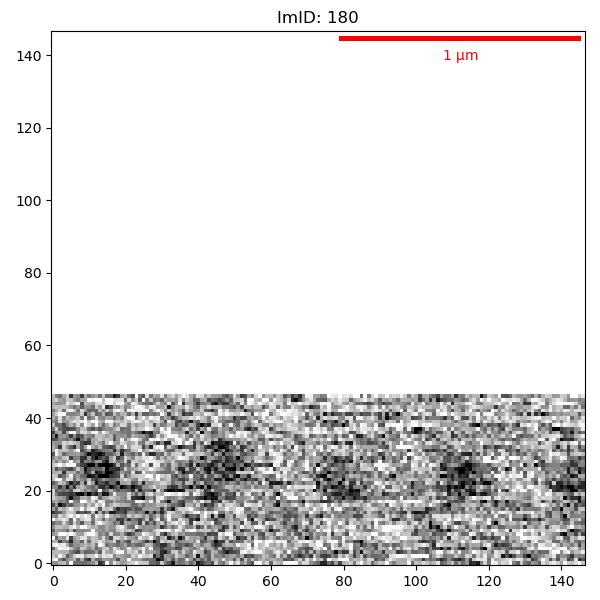

In [300]:
## Maxymus plotting
fname = join(folder_save, "MAXYMUS_%s-%03d.png" % (date, n_pos))
fig, ax = max_plot(
    data,
    fname,
    pixel_size ,
    1,
    "r",
    size=(size[1], size[0]),
    units="um",
    save=False,
    scale=(1, 95),
    cmap="gray",
)
ax.set_title("ImID: %03d" % n_pos)
print("Saving: %s" % fname)
plt.tight_layout()
plt.savefig(fname, dpi=300)

# Loop this 

Loading: Y:\2024-04-17\Sample_Image_2024-04-17_383.hdf5
Loading: Y:\2024-04-17\Sample_Image_2024-04-17_383.hdf5
Saving: C:\Users\gaebel\Desktop\MBI Orga\Beamtimes\04_24_MAXYMUS\Bilder\MAXYMUS_2024-04-17-383_looped.png
Loading: Y:\2024-04-17\Sample_Image_2024-04-17_384.hdf5
File does not exist!


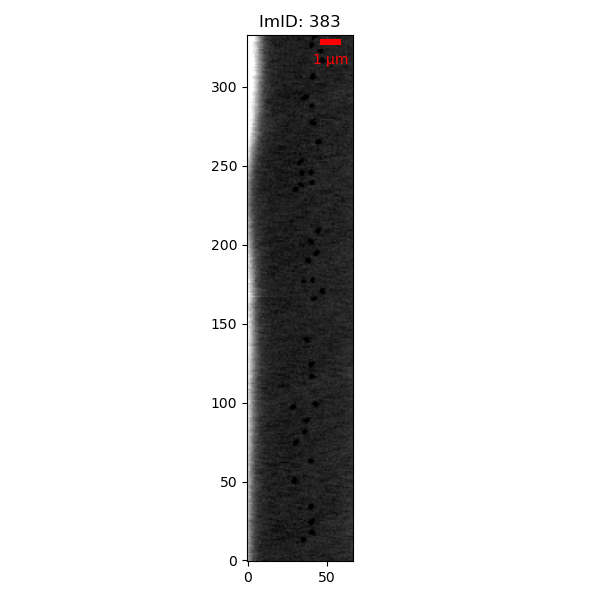

In [403]:
#### Define image ids
im_ids = np.arange(383,384+1)

# Loop over different ids
images = []
for im_id in im_ids:
    if XMCD:
        pos = load_image(im_id)
        neg = load_image(n_neg)
        data = np.log(pos / neg)
        topo = pos + neg

        figure_save = join(
            folder_save, "MAXYMUS_%s-%03d_%03d_looped.png" % (date, im_id, n_neg)
        )

    elif XMCD is False:
        data, exist_flag = load_image(im_id)
        figure_save = join(folder_save, "MAXYMUS_%s-%03d_looped.png" % (date, im_id))

    if exist_flag is True:
        pixel_size, pixel_size_x = get_pixel_size(im_id)
        images.append(data)
        size = np.array(data.shape) / 50

        #reduce gradient in image
        if False: #reduce y-Gradient in image
            fig = plt.figure()
            temp = np.mean(data[:, :], axis=1) # choose collumn or row
            plt.plot(temp)
            data = np.flip(np.rot90(np.rot90(data)/temp))

        # Plot and save
        fig, ax = max_plot(
            data,
            fname,
            pixel_size ,
            1,
            "r",
            size=(size[1], size[0]),
            units="um",
            save=False,
            scale=(1, 99),  # (20, 61), #(6, 63)
            cmap="gray",
            # rang=(20, 40),
        )
        ax.set_title("ImID: %03d" % im_id)
        print("Saving: %s" % figure_save)
        plt.tight_layout()
        plt.savefig(figure_save, dpi=300)


interactive(children=(FloatRangeSlider(value=(1540.0, 1874.0), description='contrast', layout=Layout(width='50…

interactive(children=(IntSlider(value=0, description='nr', max=1), Output()), _dom_classes=('widget-interact',…

Text(0.5, 1.0, 'All looped images')

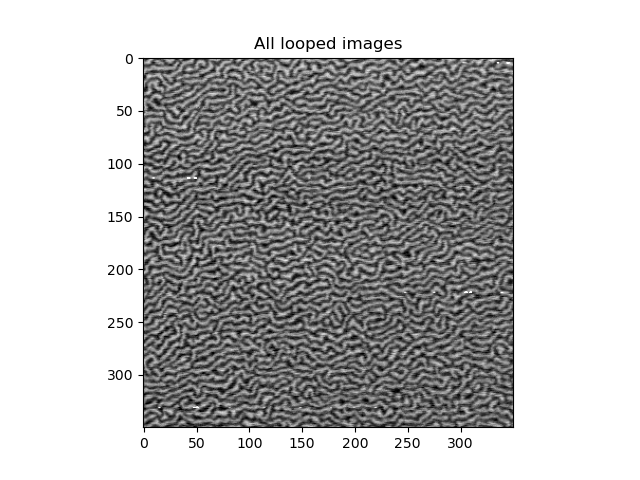

In [376]:
# Slide Show viewer of all images
fig, ax = cimshow(images, cmap="gray")
ax.set_title("All looped images")

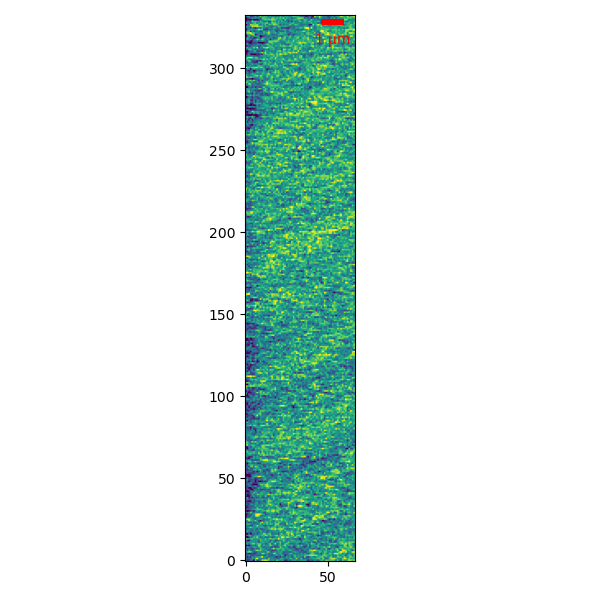

In [402]:
#get difference between images, the images used are the first and second image from the "loop over multiple images"-Cell
to_plot = images[0] - images[1]
fig, ax = max_plot(
        to_plot,
        fname,
        pixel_size,
        1,
        "r",
        size=(size[1], size[0]),
        units="um",
        save=False,
        scale=(1, 99),  # (20, 61), #(6, 63)
        cmap="viridis",
        rang=(20, 40),
    )

figure_save = join(folder_save, "MAXYMUS_%s-%03d_looped" % (date, im_id))
plt.savefig(figure_save+"_difference.png", dpi=300)

# Pandas data handling playground

In [318]:
def load_data_dict(file_prefix, scan_id):
    fname = join(data_folder, "%s_%03d.hdf5" % (file_prefix, scan_id))
    print("Loading: %s" % fname)

    data = dict()

    if os.path.exists(fname):
        with h5py.File(fname, "r") as f:
            data["scan_id"] = scan_id
            for key in f[entryNumber][detector].keys():
                data[key] = f[entryNumber][detector][key][()]
    else:
        print("File does not exist!")
        data["scan_id"] = scan_id

    return data


def load_data_to_pandas(scan_id_list, stack=False):
    if stack is True:
        prefix = "Sample_Stack_%s" % date
    elif stack is False:
        prefix = "Sample_Image_%s" % date

    data = []
    for scan_id in scan_id_list:
        data.append(load_data_dict(prefix, scan_id))

    df = pd.DataFrame(data)
    df.set_index("scan_id", inplace=True)

    return df


def get_title(scan_id, value, key):
    if key == "magnetic_field":
        title = "ScanId: %d, Magnetic Field: %.1f mT" % (scan_id, value)
    else:
        title = "ScanId: %d, %s: %.4f " % (scan_id, key, value)

    return title

In [377]:
# Define for loading
scan_ids =  [326,327]#np.arange(279, 305)
stack = False
scan_key = "count_time"

# Loading of data
data = load_data_to_pandas(scan_ids, stack=stack)
data = data.dropna(how="all")
data

Loading: Y:\2024-04-17\Sample_Image_2024-04-17_326.hdf5
Loading: Y:\2024-04-17\Sample_Image_2024-04-17_327.hdf5


count_time                                               data  \
scan_id                                                                 
326        [0.001]  [[1721.0, 1652.0, 1610.0, 1581.0, 1611.0, 1654...   
327        [0.001]  [[1802.0, 1718.0, 1739.0, 1791.0, 1818.0, 1810...   

          energy                                           sample_x  \
scan_id                                                               
326      [778.5]  [-653.262599501325, -653.242599501325, -653.22...   
327      [778.5]  [-653.262599501325, -653.242599501325, -653.22...   

                                                  sample_y     stxm_scan_type  
scan_id                                                                        
326      [1915.372614683942, 1915.392614683942, 1915.41...  [b'sample image']  
327      [1915.372614683942, 1915.392614683942, 1915.41...  [b'sample image']

interactive(children=(FloatRangeSlider(value=(1532.0, 1822.0), description='contrast', layout=Layout(width='50…

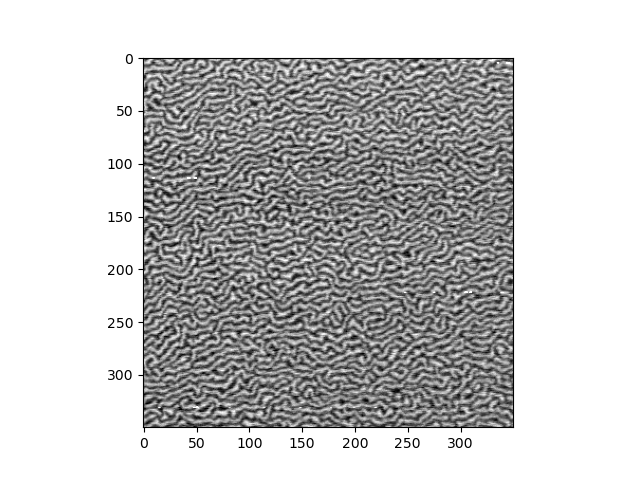

In [378]:
# Slide show image viewer
fig, ax = cimshow(data["data"].values[0], cmap="gray")

### Looping

Creating folder C:\Users\gaebel\Desktop\MBI Orga\Beamtimes\04_24_MAXYMUS\Bilder\count_time_309


TypeError: Invalid shape (500,) for image data

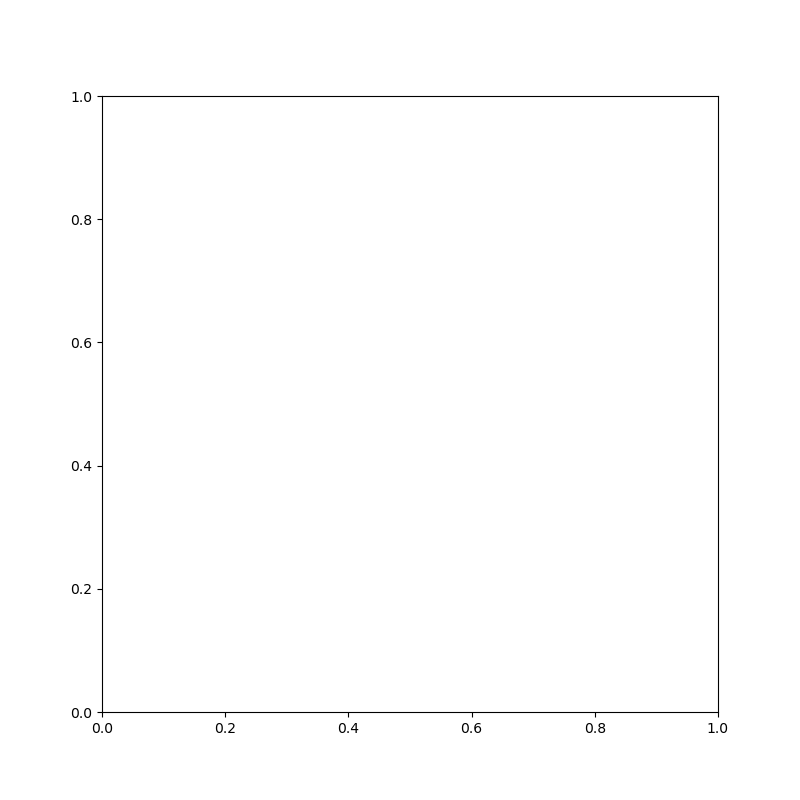

In [364]:
for j, scan_id in enumerate(data.index.values):
    # Plot hysteresis or any other key
    folder = join(folder_save, "%s_%d" % (scan_key, scan_id))
    if not (os.path.exists(folder)):
        print("Creating folder " + folder)
        os.makedirs(folder)

    flist = []
    for i, xdata in enumerate(data[scan_key].values[j]):
        image = data["data"].values[j][i]
        vmin, vmax = np.percentile(image, [1, 99])

        fig, ax = plt.subplots(figsize=(8, 8))
        ax.imshow(image, vmin=vmin, vmax=vmax, cmap="gray")
        ax.set_title(get_title(scan_id, xdata, scan_key))

        pixel_size = np.round(
            np.mean(
                np.abs(
                    data["sample_x"].values[j][0:-2] - data["sample_x"].values[j][1:-1]
                )
            ),
            3,
        )
        scalebar = ScaleBar(
            pixel_size,
            units="um",
            frameon=False,
            color="r",
            fixed_value=1,
            location=1,
        )

        plt.gca().add_artist(scalebar)

        fname = join(folder, "%s_ScanID_%03d_%03d.png" % (scan_key, scan_id, i))
        flist.append(fname)
        # print("Saving: %s" % fname)
        plt.savefig(fname)

    # Load files
    var = [imageio.imread(file) for file in flist]
    images = np.stack(var, axis=0)
    gif_path = join(folder_save, "%s_ScanID_%03d.gif" % (scan_key, scan_id))
    print(f"Now saving:", gif_path)
imageio.mimsave(gif_path, var, fps=2, loop = 0)

### FFT

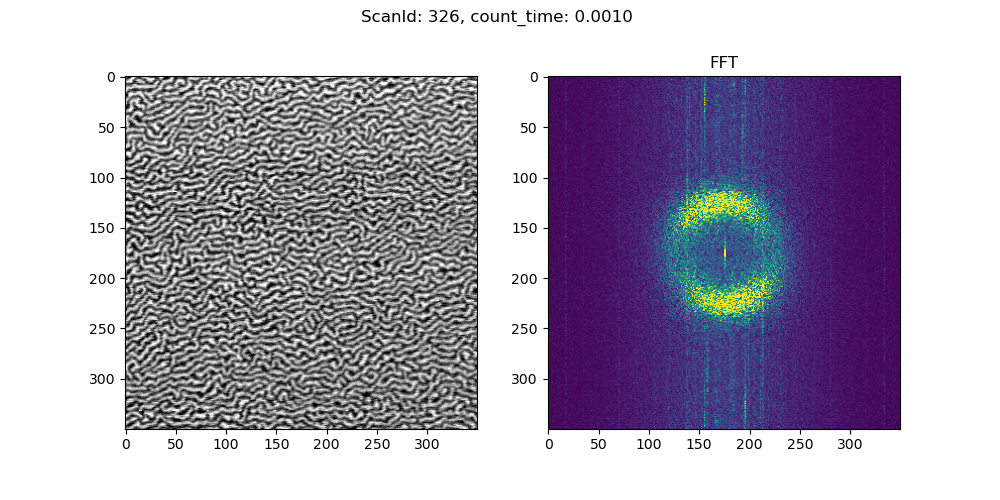

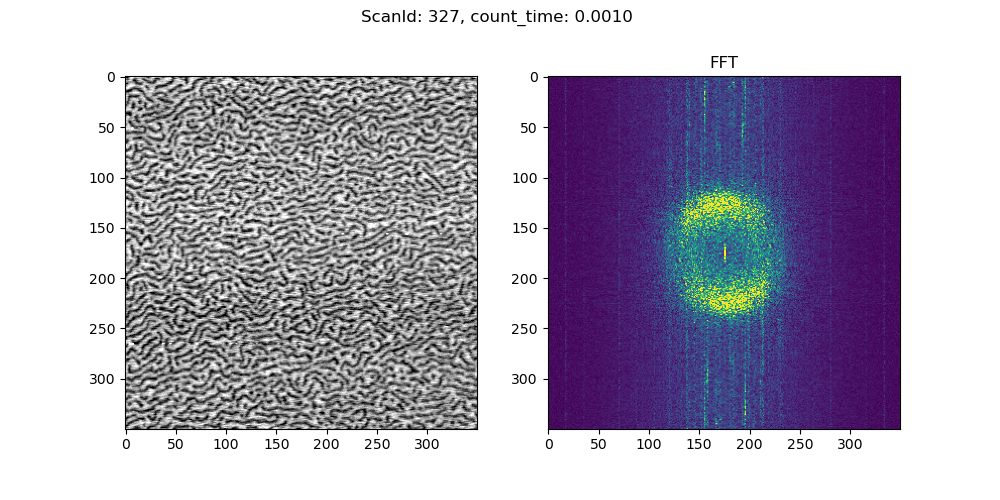

In [379]:
for j, scan_id in enumerate(data.index.values):
    for i, xdata in enumerate(data[scan_key].values[j]):
        image = data["data"].values[j]
        vmin, vmax = np.percentile(image, [1, 99])

        fig, ax = plt.subplots(1,2,figsize=(10, 5))
        fig.suptitle(get_title(scan_id, xdata, scan_key))
        ax[0].imshow(image, vmin=vmin, vmax=vmax, cmap="gray")

        image = np.abs(FFT(data["data"].values[j]))
        #image = np.log10(np.abs(FFT(data["data"].values[j])))
        vmin, vmax = np.percentile(image, [1, 99])
        ax[1].imshow(image, vmin=vmin, vmax=vmax)
        ax[1].set_title("FFT")

### Other

In [ ]:
plt.close("all")

In [ ]:
# Plot x-y positions
xdata = data["sample_x"].tolist()
ydata = data["sample_y"].tolist()
print(
    "x-data: %0.2f, %0.2f , y-data: %0.2f, %0.2f"
    % (np.min(xdata), np.max(xdata), np.min(ydata), np.max(ydata))
)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("ScanId: %s" % n_pos)
for idx in range(len(xdata)):
    ax[0].plot(xdata[idx], "o")
    ax[0].set_xlabel("Position idx")
    ax[0].set_ylabel("sample_x")
    ax[0].grid()

for idx in range(len(ydata)):
    ax[1].plot(ydata[idx], "o")
    ax[1].set_xlabel("Position idx")
    ax[1].set_ylabel("sample_y")
    ax[1].grid()